In [21]:
%load_ext autoreload
%autoreload 2

import fooof
from fooof.sim.gen import gen_aperiodic      # for looking at aperiodic details
from fooof.plts.spectra import plot_spectrum # for looking at aperiodic details
from fooof.plts.periodic import plot_peak_fits 
from fooof.plts.periodic import plot_peak_params
#from fooof.plts.annotate import plot_annotated_peak_search

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cycler
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
from scipy.io import loadmat
import math

from data_utils import load_and_fit, invert_peak_data
from plot_tools import plotFlatComps, peakPlot, peakDataScatter, exponentPlot, peakDistr
from fooof.sim.gen import gen_power_spectrum

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 

from fooof.plts.annotate import plot_annotated_peak_search 
from plot_tools import _prox_query

#Peak Ploting
from fooof.bands import Bands
from fooof.analysis import get_band_peak_fg
from fooof.sim.gen import gen_group_power_spectra
from fooof.sim.params import param_jitter
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


`peak_params`
- CF: center frequency of the extracted peak
- PW: power of the peak, over and above the aperiodic component
- BW: bandwidth of the extracted peak

Peak Search Stopping Criteria

call using fm.____

max_n_peaks (int) default: infinite

The maximum number of peaks that can be extracted from a given power spectrum. The algorithm will halt searching for new peaks when this number is reached. Note that peaks are extracted iteratively by height (over and above the aperiodic component), and so this approach will extract (up to) the n largest peaks.

peak_threshold (in units of standard deviation) default: 2.0

The threshold, in terms of standard deviation of the aperiodic-removed power spectrum, above which a data point must pass to be considered a candidate peak. Once a candidate peak drops below this threshold, the peak search is halted (without including the most recent candidate).

min_peak_height (units of power - same as the input spectrum) default: 0

The minimum height, above the aperiodic fit, that a peak must have to be extracted in the initial fit stage. Once a candidate peak drops below this threshold, the peak search is halted (without including the most recent candidate). Note that because this constraint is enforced during peak search, and prior to final peak fit, returned peaks are not guaranteed to surpass this value in height.

There are two different height-related halting conditions for the peak searching. By default, the relative (standard-deviation based) threshold is defined, whereas the absolute threshold is set to zero (this default is because there is no general way to set this value without knowing the scale of the data). If both are defined, both are used and the peak search will halt when a candidate peak fails to pass either the absolute, or relative threshold.

Helper Function

In [22]:
# plot single cluster redefined
def plotSingleClFlatComps(fit_data, mark_peak, draw_omit = False):
    specfreqs, group_spec =  fit_data['data']['freqs'], fit_data['data']['spectra']    
    peak_data = fit_data['peak data']['CF']
    
    component_size = np.size(fit_data['data']['spectra'])
    fig, (ax1, ax2) = plt.subplots(component_size)
        
    peak_comps = peak_data[:,1] #components that have peaks
    bumpy_comps = set([int(i) for i in peak_comps])

    cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
    n_ = group_spec.shape[1] #number of components
    color = cmap(np.linspace(0, 1,n_))
    mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
        
    flat_comps = 'Non osc comps: '
    for c in range(n_): #loop over comps
        peak_freqs = []
        if mark_peak:
            marker = 'D'
        else:
            marker = ''
        linestyle = '-'
            
        if c not in bumpy_comps:
            linestyle = '--'; marker = ''
            flat_comps += "{}, ".format(c)
        else: #append peaks to peak_freqs to read later and plot marker on spectra
            for p in peak_data:
                if p[1] == c:
                    peak_freqs.append(p[0])
        #convert freqs to x axis indeces
        #markers_on = [list(np.floor(specfreqs)).index(i) for i in np.floor(np.array(peak_freqs))]
        markers_on = [_prox_query(p,specfreqs) for p in peak_freqs]
        plt.semilogy(specfreqs[:84], group_spec[:,c][:84], marker = marker, linestyle = linestyle, markevery = markers_on, markersize=4)
        plt.ylabel('db'); 
    plt.title(flat_comps)
    plt.tight_layout()
    
    

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Jul 16 11:59:24 2020',
 '__version__': '1.0',
 '__globals__': [],
 'specdata': array([[array([[ 38.161022 ,  13.302775 ,  41.774883 , ...,  39.85839  ,
           2.9801197,  13.0368805],
        [ 37.51109  ,  14.77334  ,  42.08008  , ...,  39.623116 ,
           4.389848 ,  14.121267 ],
        [ 34.514946 ,  14.539356 ,  40.49658  , ...,  37.00303  ,
           4.0553637,  13.856829 ],
        ...,
        [-11.240767 ,  13.733064 ,  14.969736 , ..., -14.791117 ,
           3.9176104,  13.377396 ],
        [-11.236082 ,  13.978722 ,  14.812073 , ..., -15.349424 ,
           3.853032 ,  13.38264  ],
        [-11.235207 ,  14.071379 ,  14.928731 , ..., -15.904181 ,
           3.8432503,  13.235606 ]], dtype=float32)],
        [array([[ 38.195553 ,  12.72689  ,  41.294884 , ...,  39.82244  ,
           3.094244 ,  13.457436 ],
        [ 37.672287 ,  14.423035 ,  41.921402 , ...,  39.8221   ,
           4.209215 , 

#### Load the data

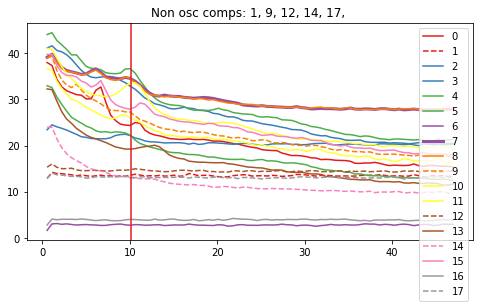

In [23]:
p_spectrum = loadmat('data/spectra/dip_only/brian_diponly_3_spectra.mat')
specfreqs, specdata = p_spectrum['specfreqs'][0], p_spectrum['specdata']
group_spec = specdata.mean(0)[0]
fg = fooof.FOOOFGroup(aperiodic_mode='fixed', verbose = False, min_peak_height = 0.025)
fg.fit(specfreqs, group_spec.T, [3, 40])
oscs = fg.get_params('peak_params', 'CF')
bumpy_comps = set([int(i) for i in oscs[:,1]])

n_ = group_spec.shape[1]
color = plt.cm.Set1(np.linspace(0, 1,n_)) #color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)
flat_comps = 'Non osc comps: '
plt.figure(figsize=(8,4))
for i in range(n_):
    lw = 1.5
    linestyle = '-'
    if i not in bumpy_comps:
        linestyle = '--'
        flat_comps += "{}, ".format(i)
    if i == 7: lw = 3
    plt.plot(specfreqs[:84], group_spec[:,i][:84], linestyle = linestyle, marker='',markevery=[17],label = str(i), lw = lw)
plt.axvline(10.151271039)
plt.legend()
plt.title(flat_comps)
plt.show()

In [32]:
group_df = load_and_fit(dimension = 'component', freqrange = [3,40], omit_r2 = 0.7, min_peak_height = .025)
type(group_df)

dict

In [33]:
group_df

{'cluster 3': {'spectral exponent': array([0.29123936, 0.26267846, 0.03804892, 0.2803736 , 0.26292009,
         0.11330341, 0.11120564, 0.25121252, 0.2266974 , 0.22719459,
         0.28929862, 0.21846028, 0.26118985]),
  'peak data': {'CF': array([[ 6.59724029,  0.        ],
          [10.9416209 ,  0.        ],
          [21.75627981,  0.        ],
          [ 9.14565534,  1.        ],
          [20.54344083,  1.        ],
          [ 9.3812437 ,  2.        ],
          [ 9.49878097,  3.        ],
          [24.8245379 ,  3.        ],
          [10.02908217,  4.        ],
          [21.645534  ,  4.        ],
          [27.96640011,  4.        ],
          [ 6.31459691,  5.        ],
          [ 9.67361714,  5.        ],
          [ 6.35345893,  6.        ],
          [ 9.73881753,  6.        ],
          [10.21857248,  8.        ],
          [10.59559866,  9.        ],
          [20.79147702,  9.        ],
          [12.68820263, 10.        ],
          [22.53388822, 10.        ],
  

#### Cluster Selection, extract spetrum data from the mat we loaded

In [25]:
# settings
cluster_check = group_df['cluster 3']
component_index = 0
freq_range_eg = [2,35]

In [26]:
spectra_cl3 = cluster_check['data']['spectra']
freq_eg = cluster_check['data']['freqs']
fm_trim = fooof.FOOOF()

# extra component spectrum from the 'spectra' as spectrum data is stored 'vertically'
component_spectra = []
for i in spectra_cl3:
    component_spectra.append(i[component_index])
spectra_eg = np.array(component_spectra)

Set Ratio Criteria

Initialize fooof for each component in the cluster, plot ap fit and original spectrum, using annotated peak search for filtering peaks

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.6716, 0.2912                                          
                                                                                                  
                                       3 peaks were found:                                        
          

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

5th 9.937924656350118
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.6199, 0.1133                                          
                                                                                                  
                                       2 peaks were found:                             

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

5th component
6th 6.311839193438033
6th 9.67555967765782
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.6166, 0.1112                                          
                                                                                                  
                                       2 peaks were 

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.6702, 0.2512                                          
                                                                                                  
                                       0 peaks were found:                                        
          

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.6669, 0.2272                                          
                                                                                                  
                                       2 peaks were found:                                        
          

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

10th component
11th 12.891711885301667
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.3398, 0.2185                                          
                                                                                                  
                                       0 peaks were found:            

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume t

11th component
                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 40 Hz                        
                                 Frequency Resolution is 0.56 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                          1.7010, 0.2612                                          
                                                                                                  
                                       3 peaks were found:                                    

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


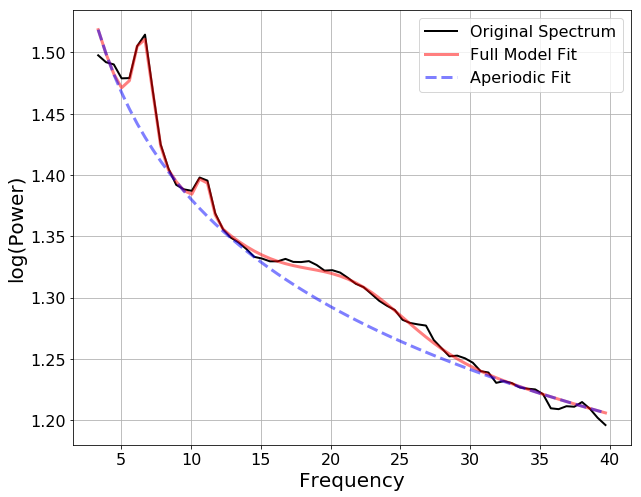

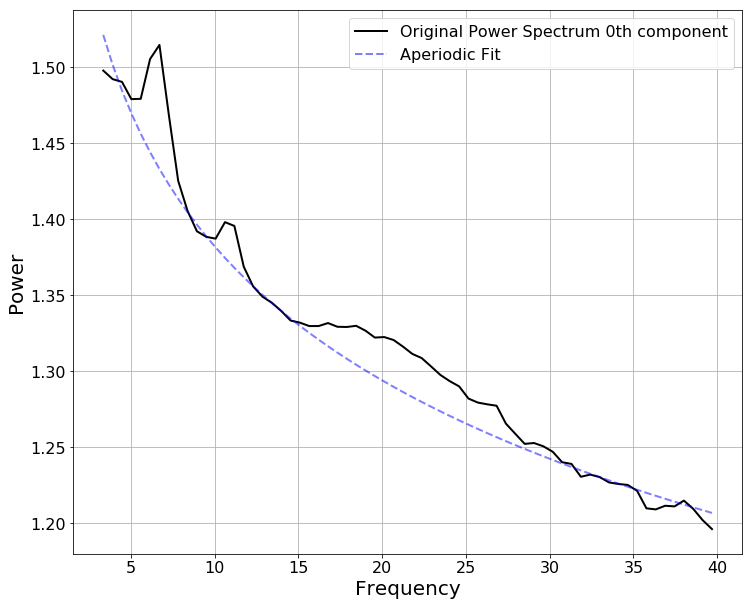

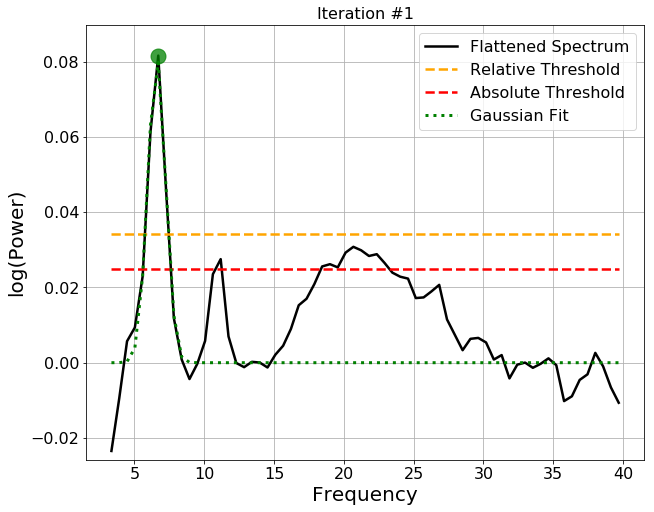

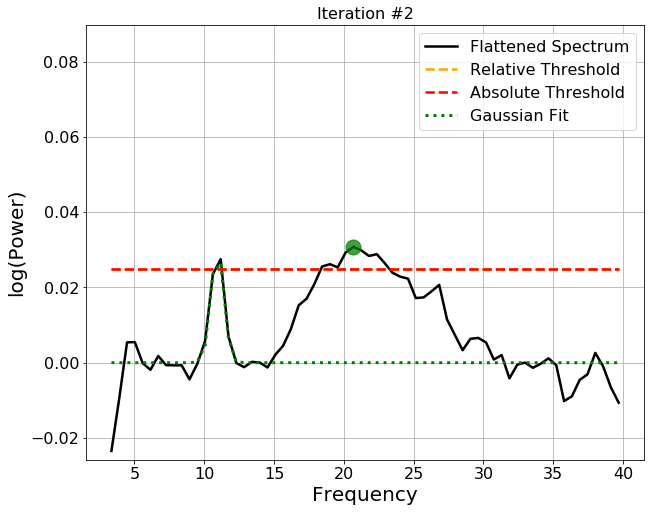

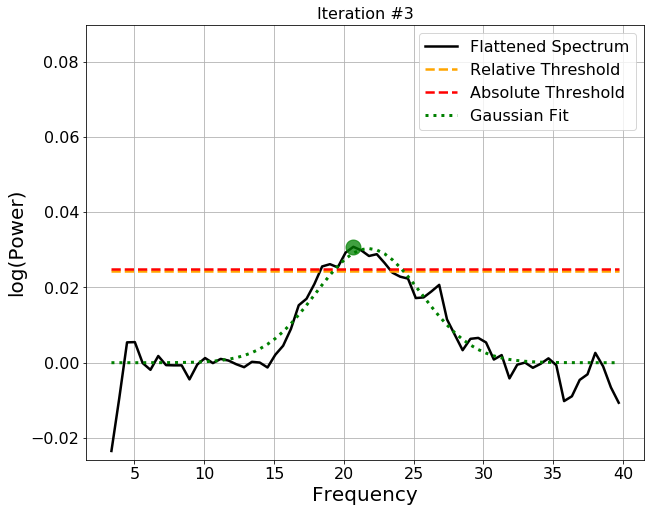

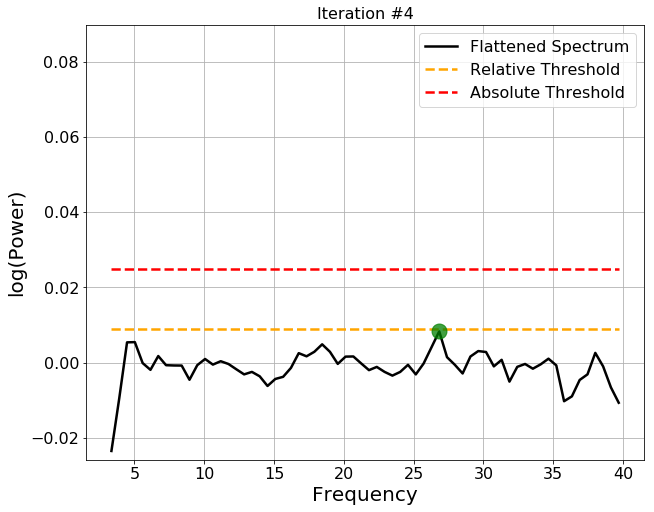

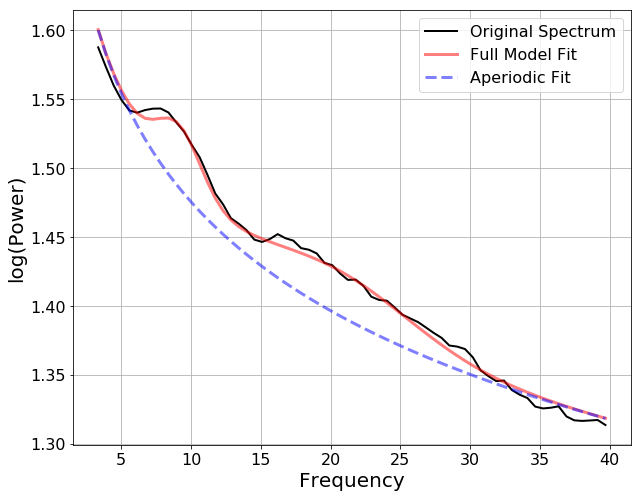

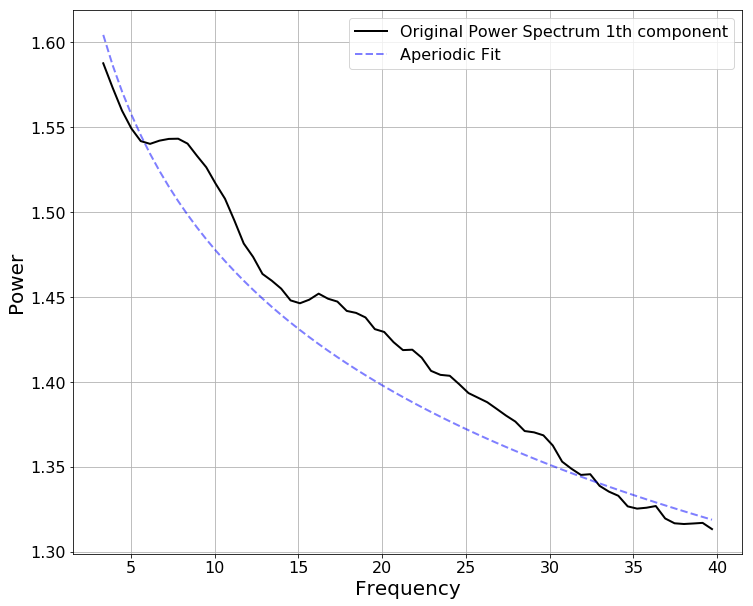

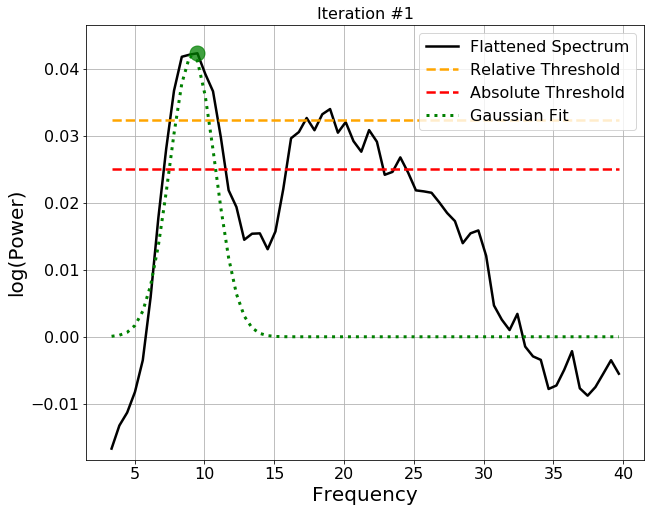

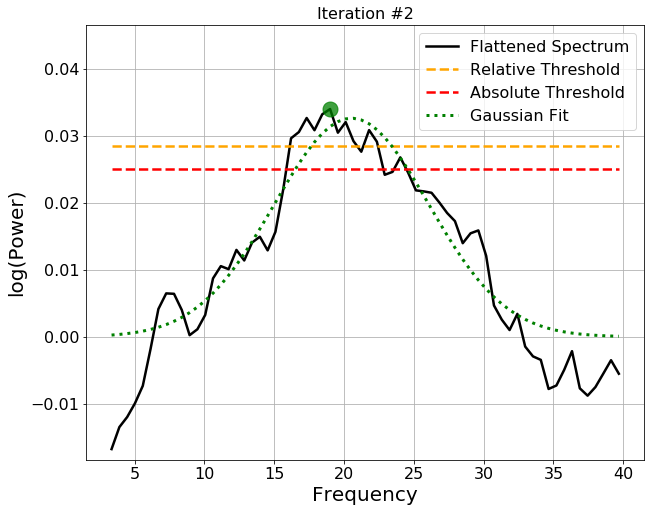

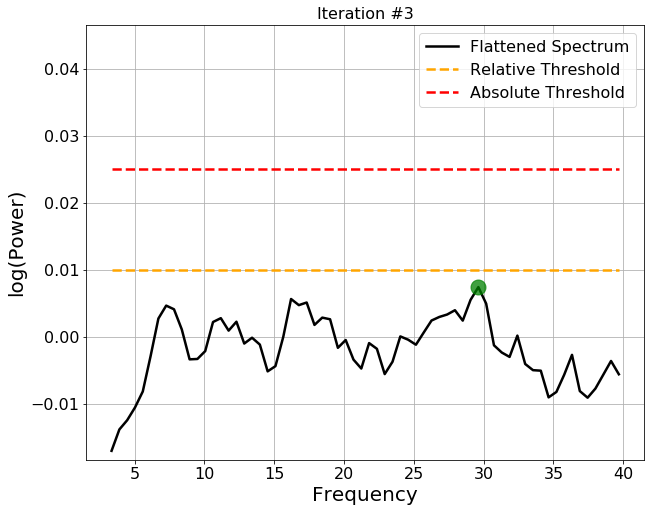

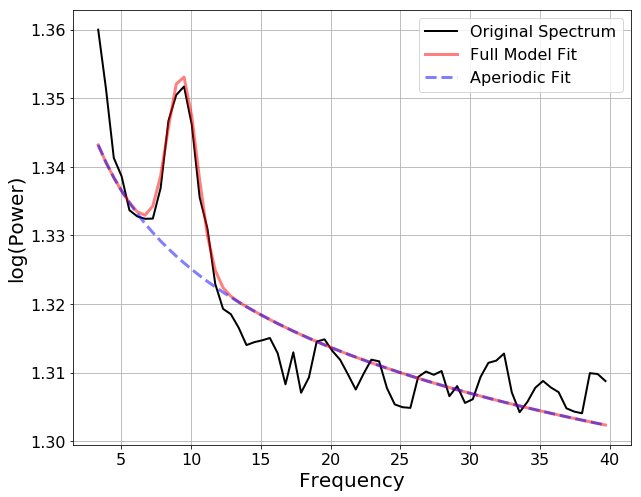

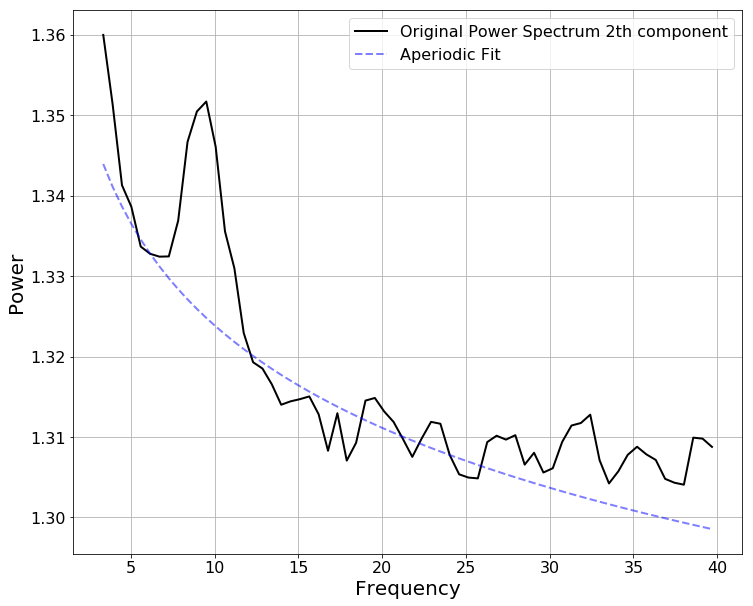

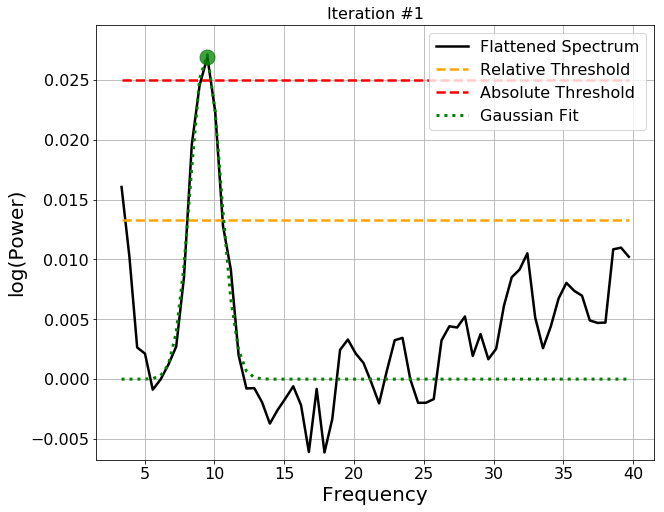

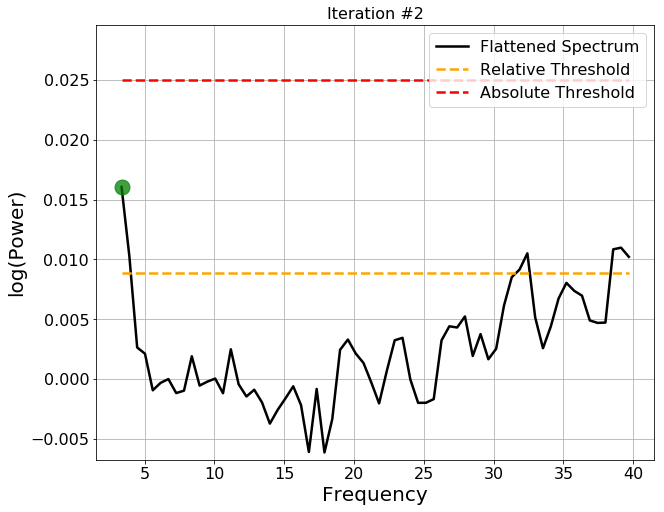

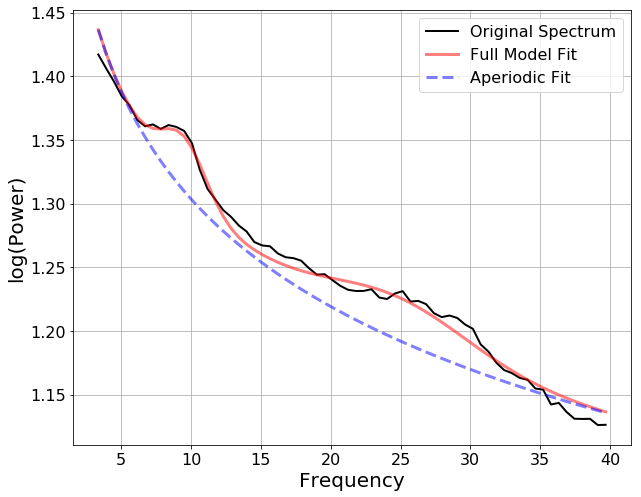

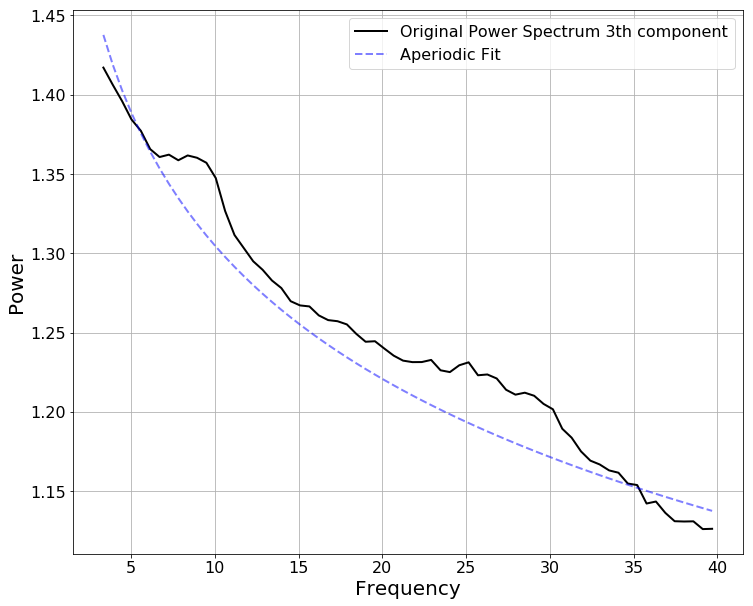

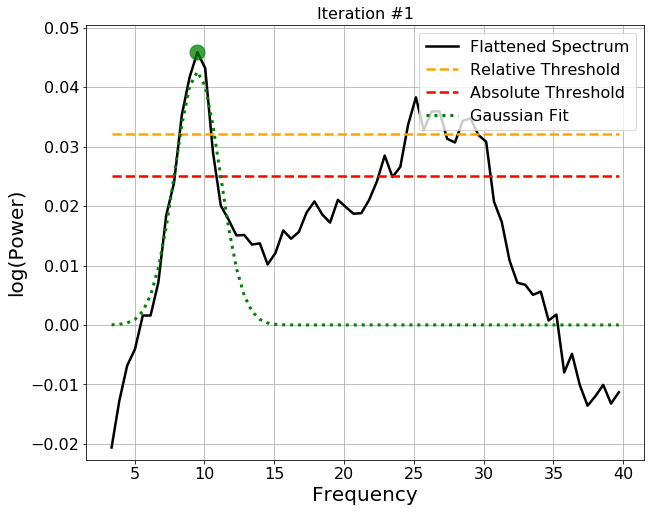

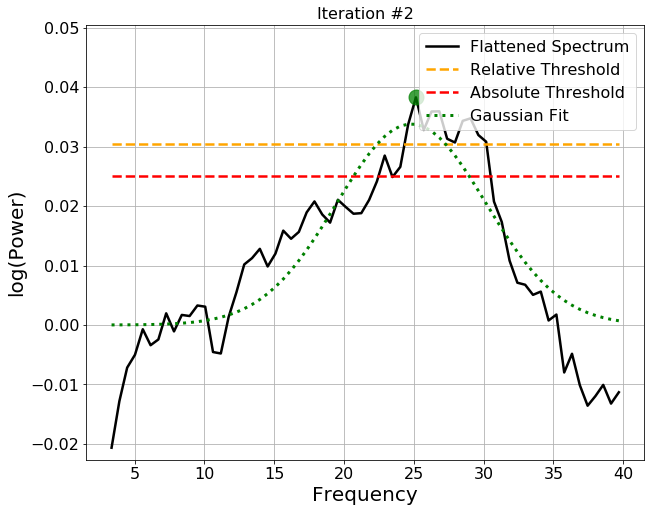

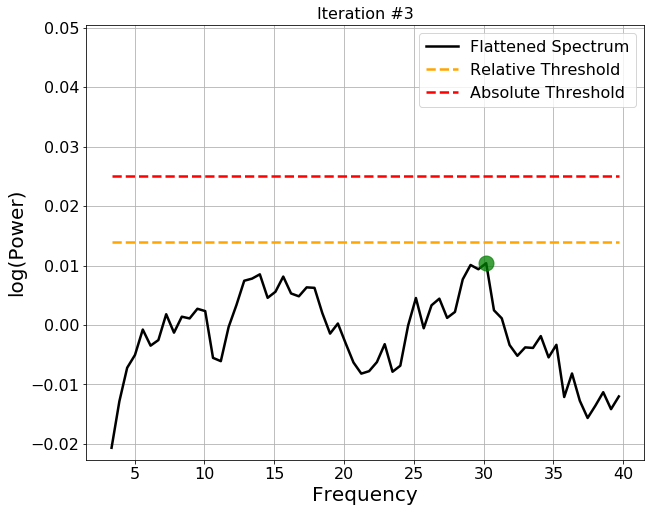

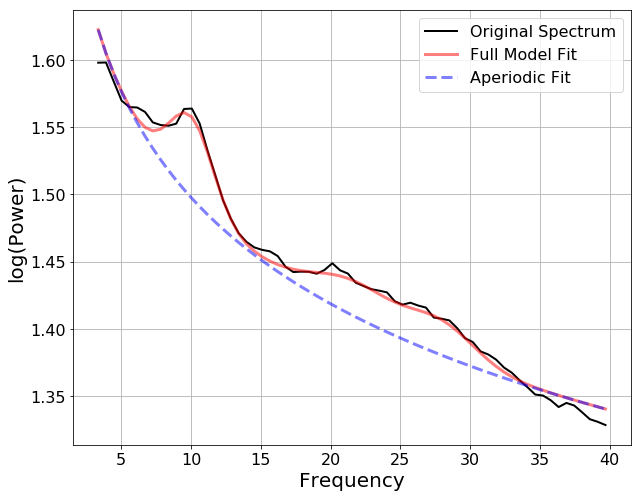

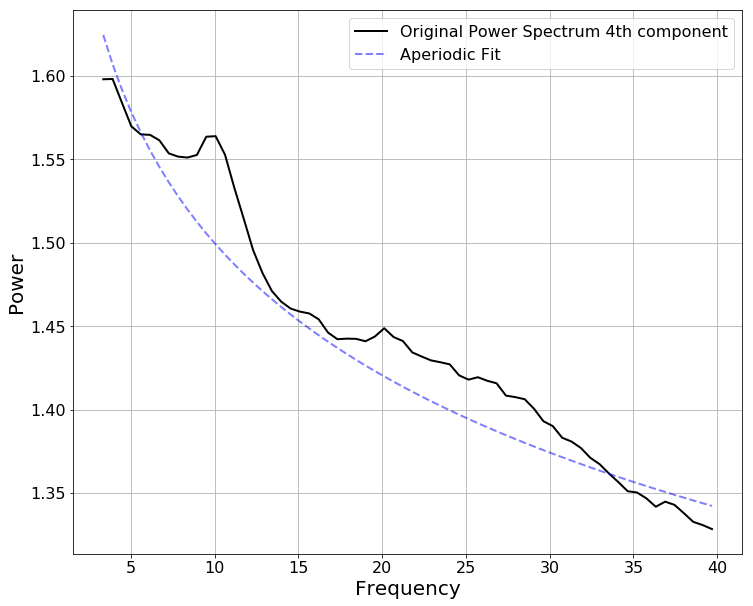

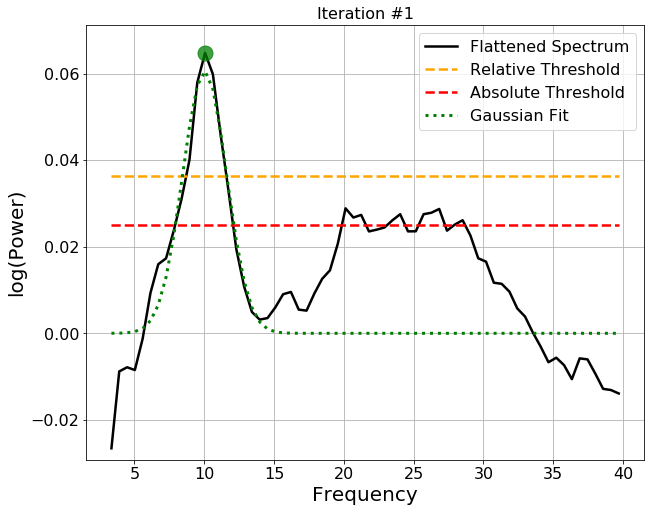

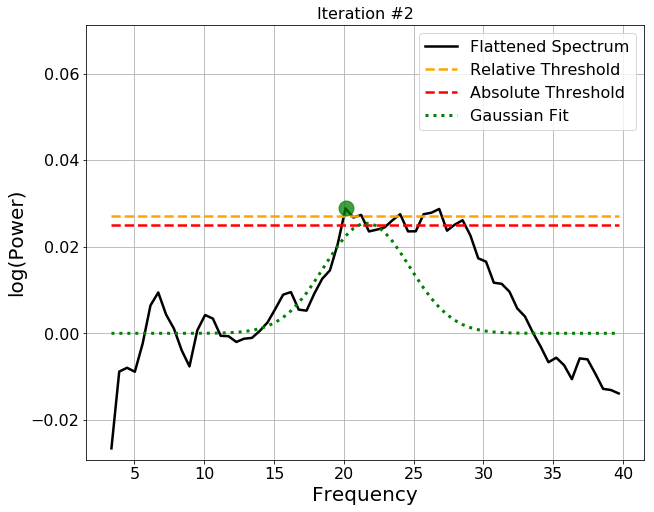

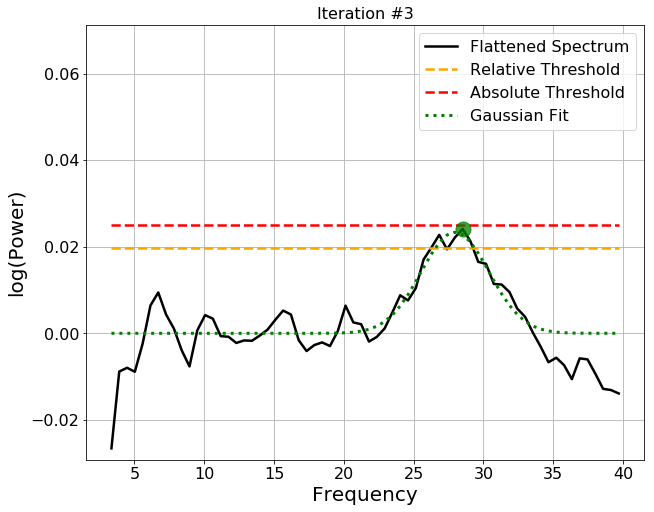

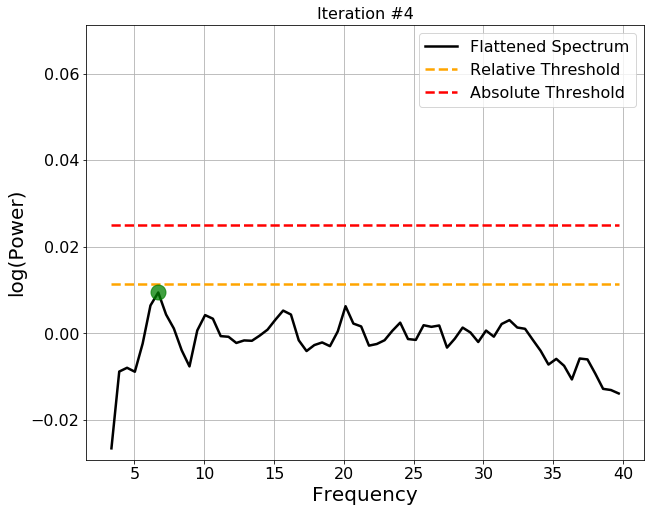

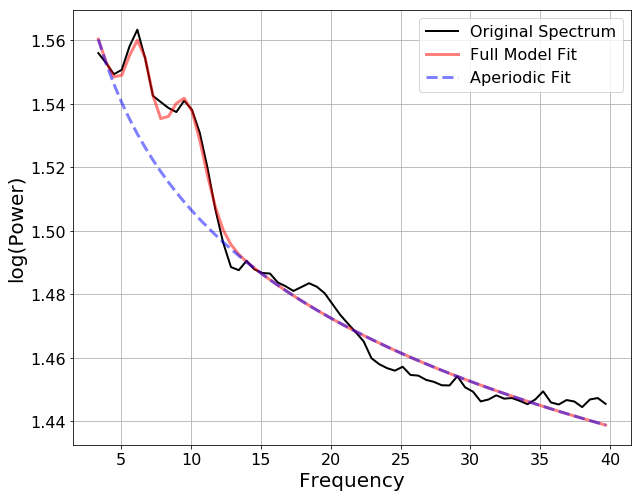

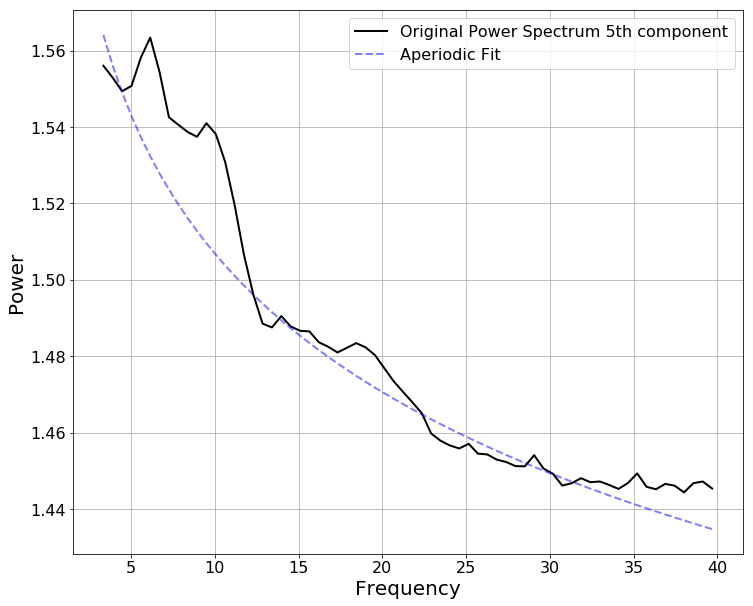

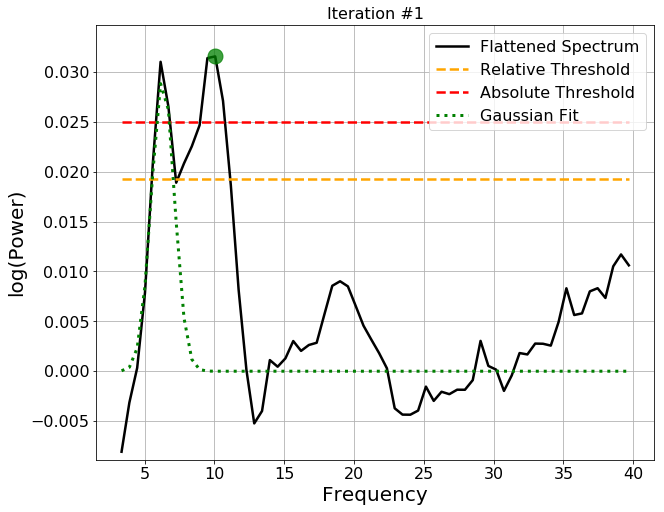

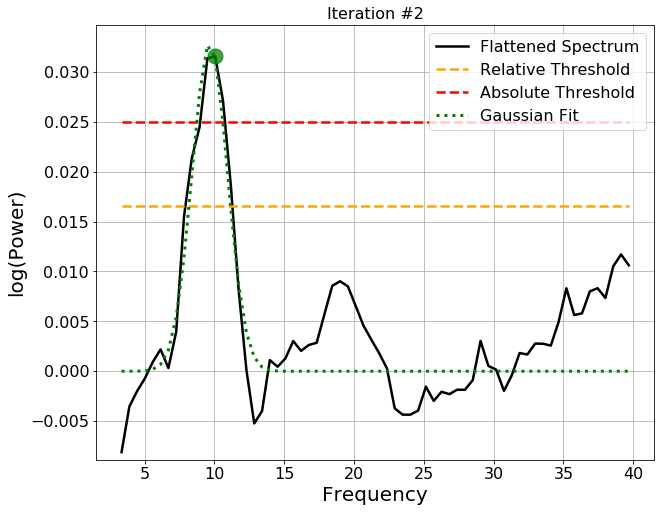

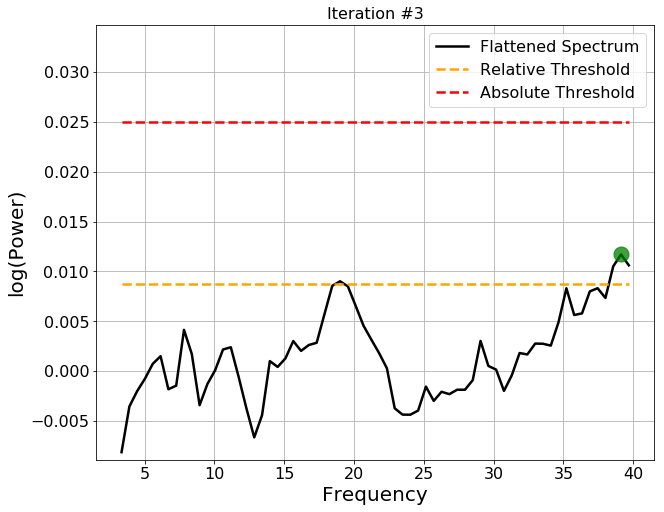

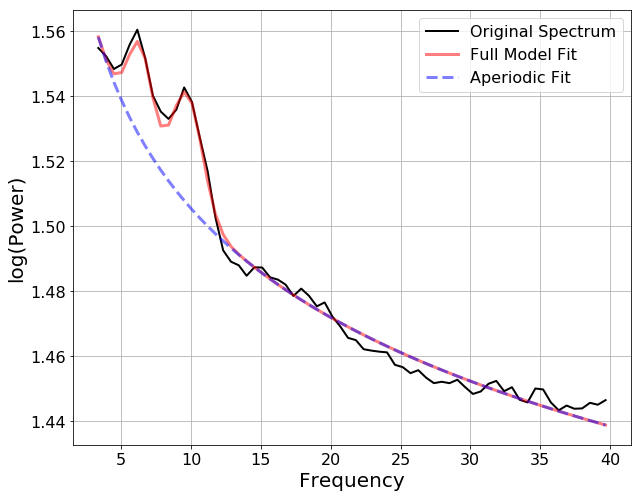

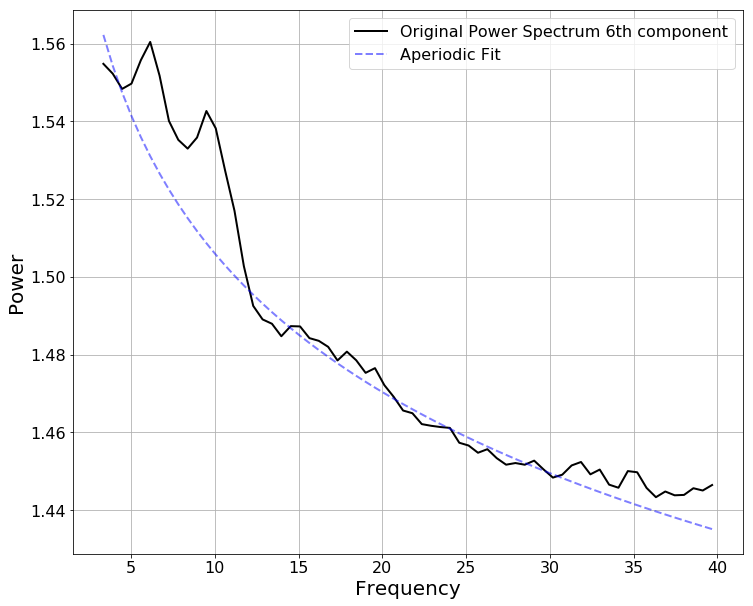

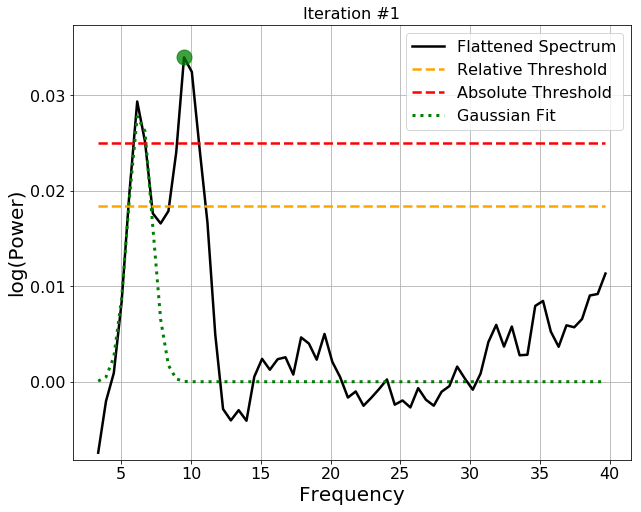

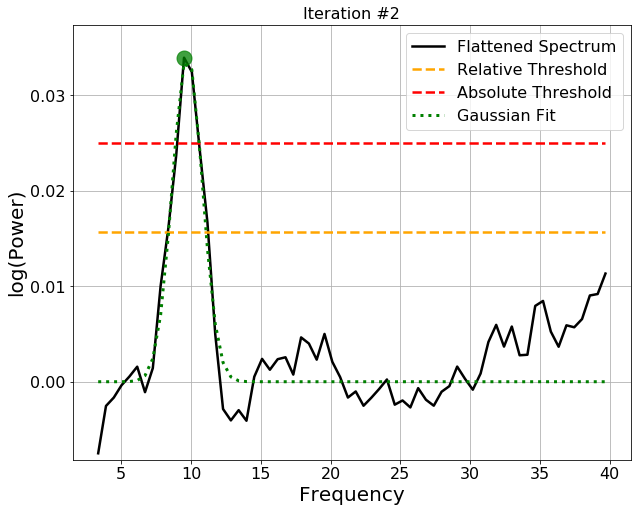

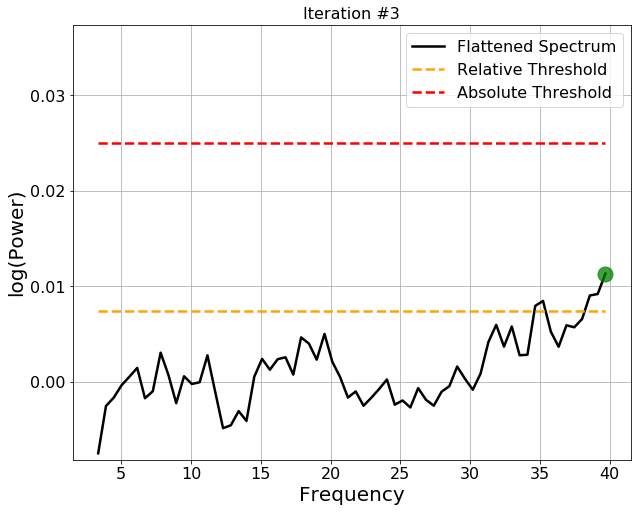

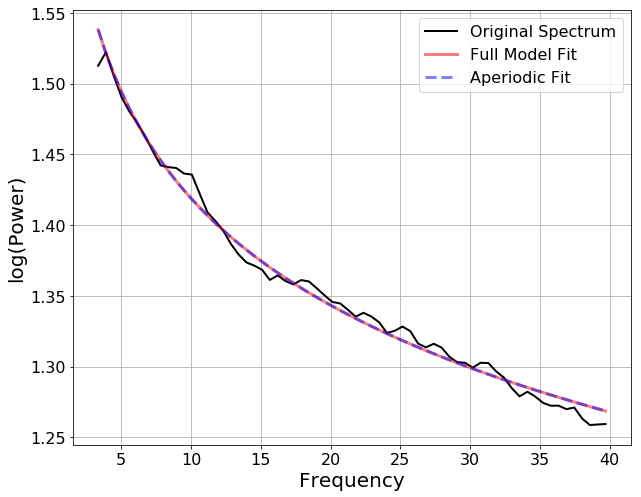

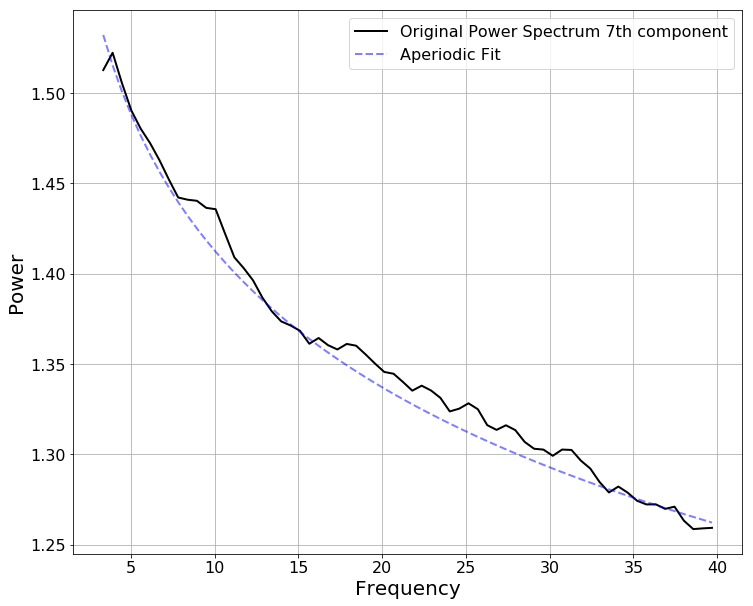

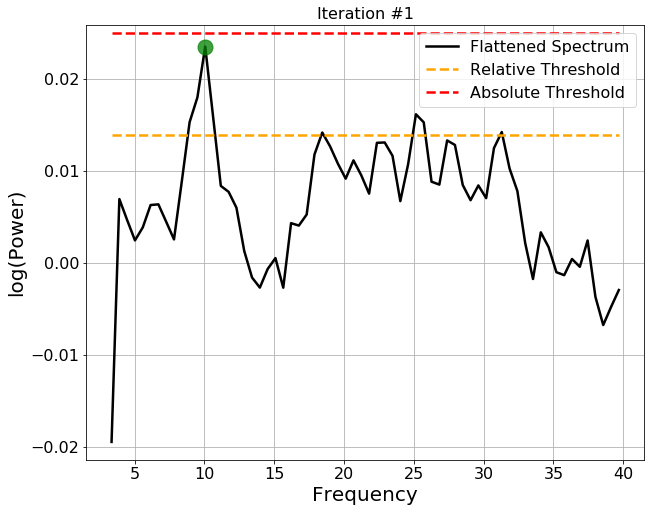

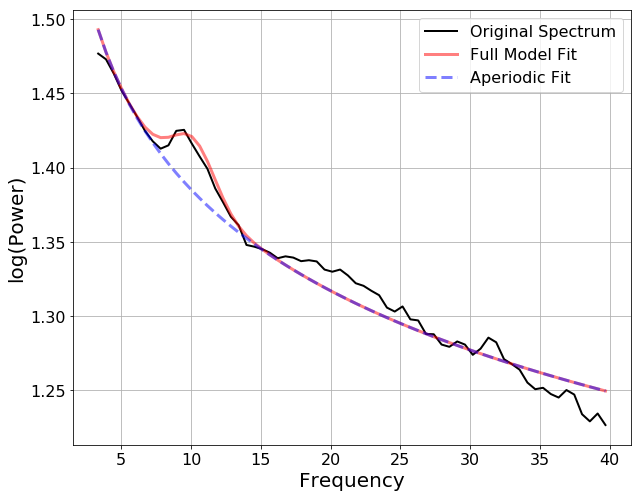

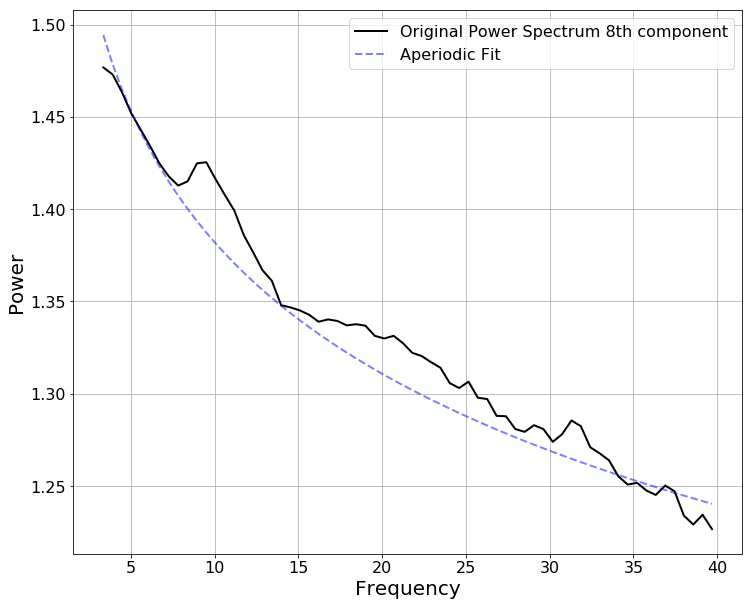

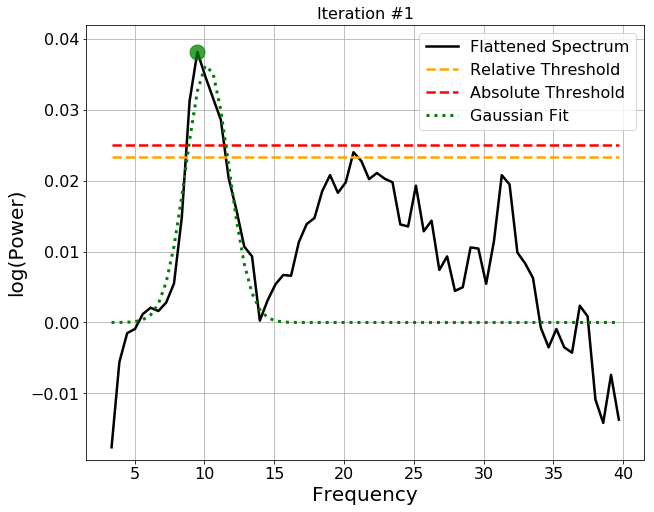

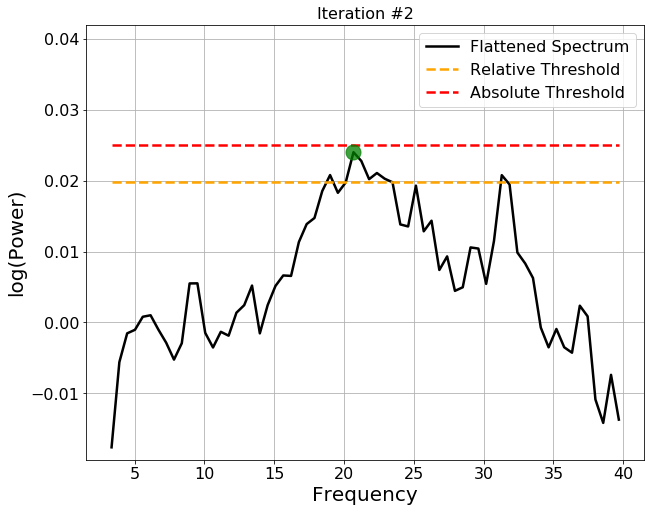

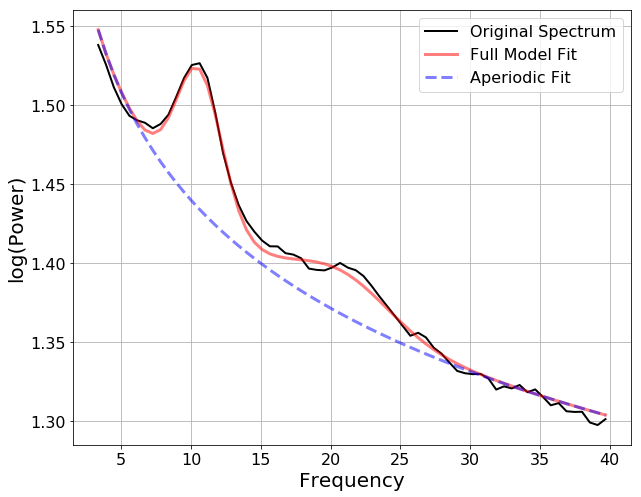

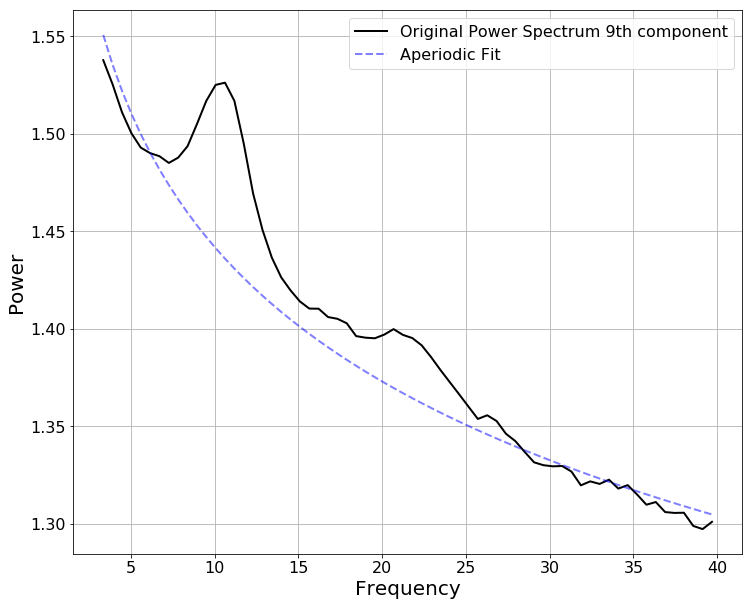

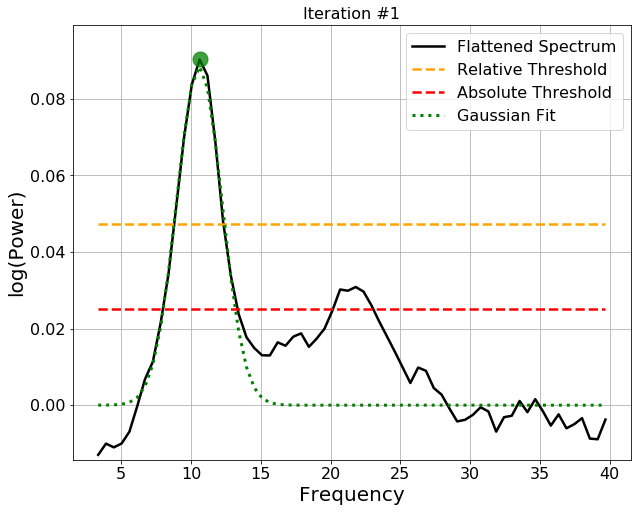

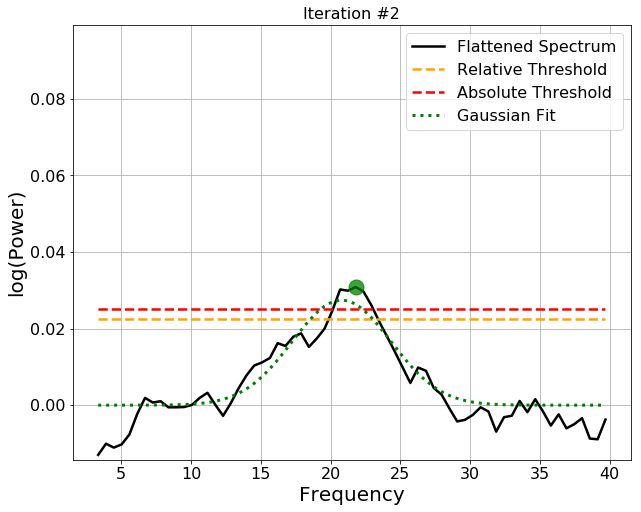

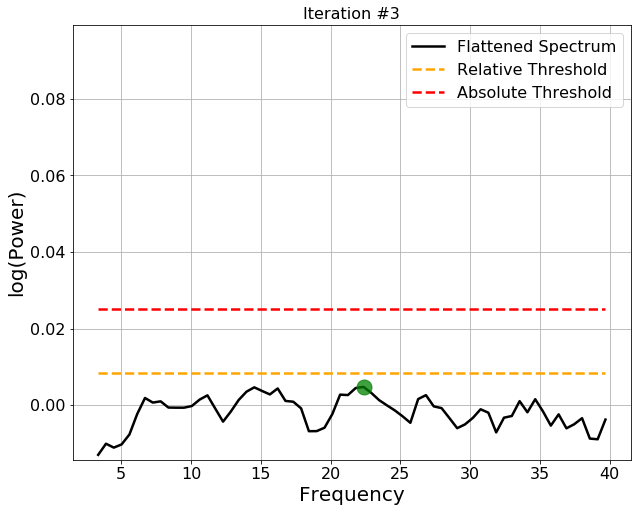

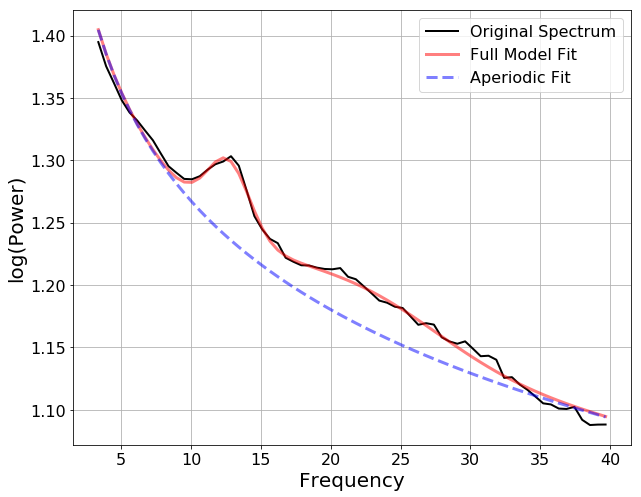

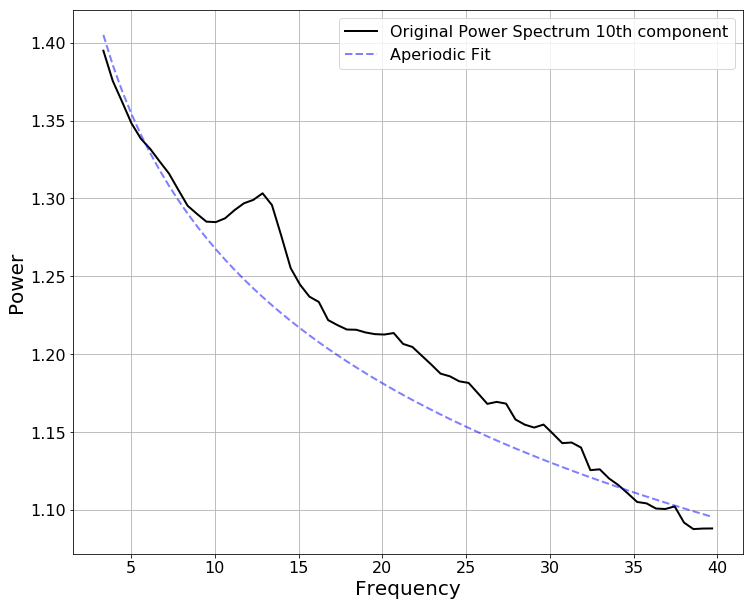

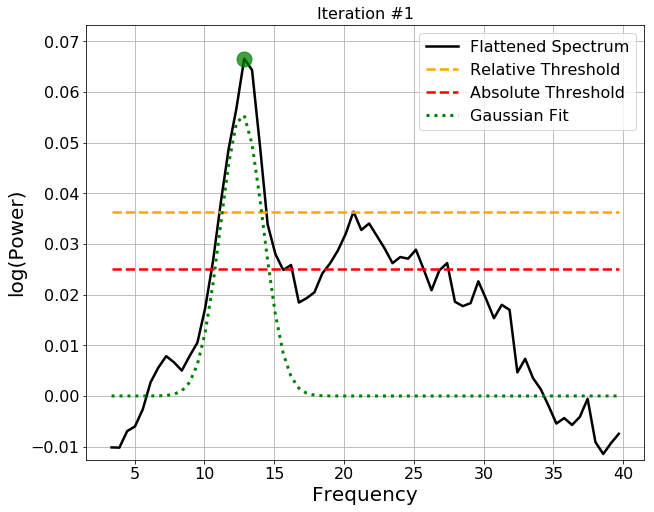

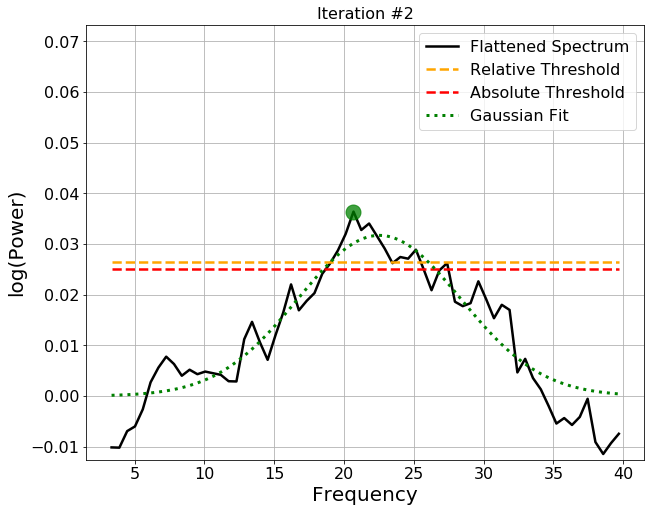

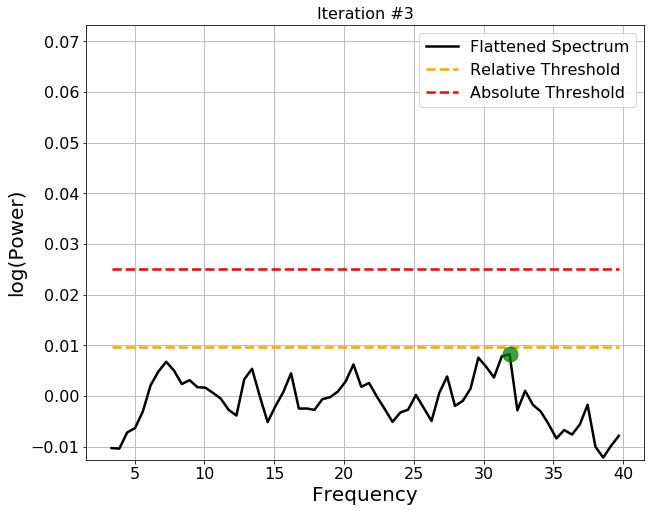

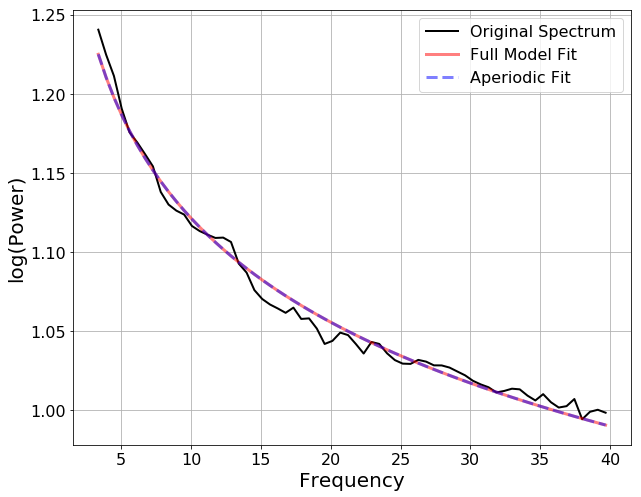

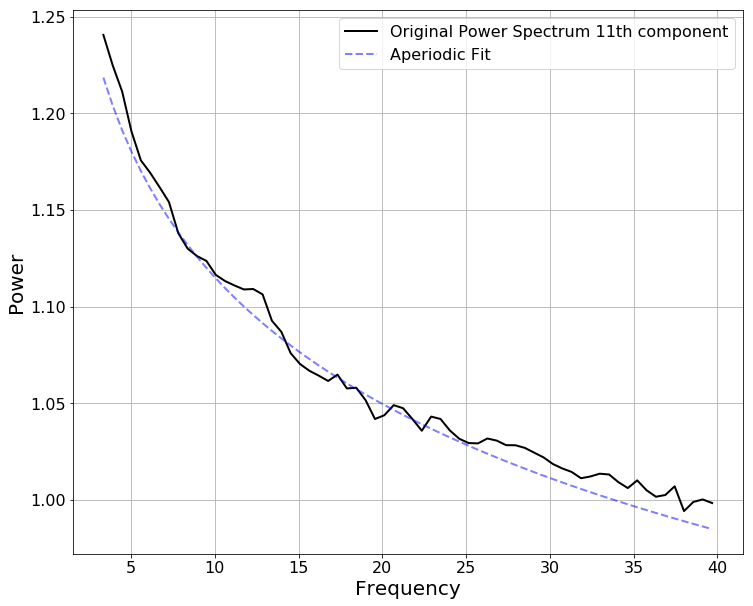

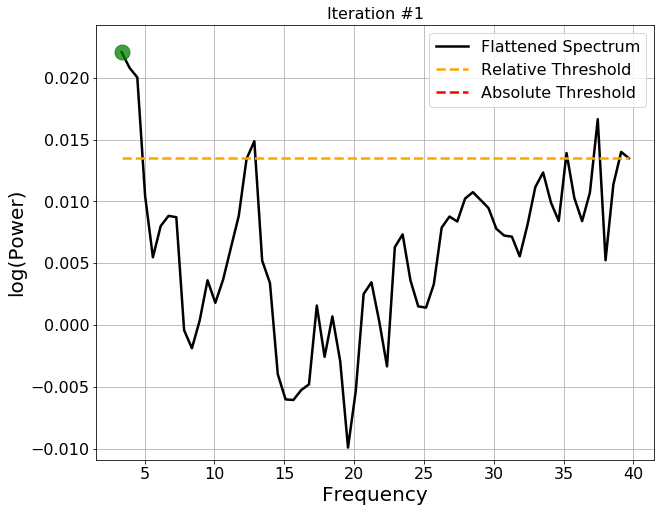

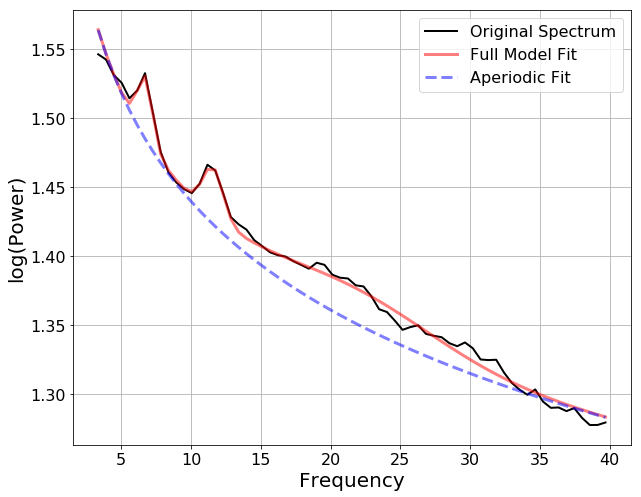

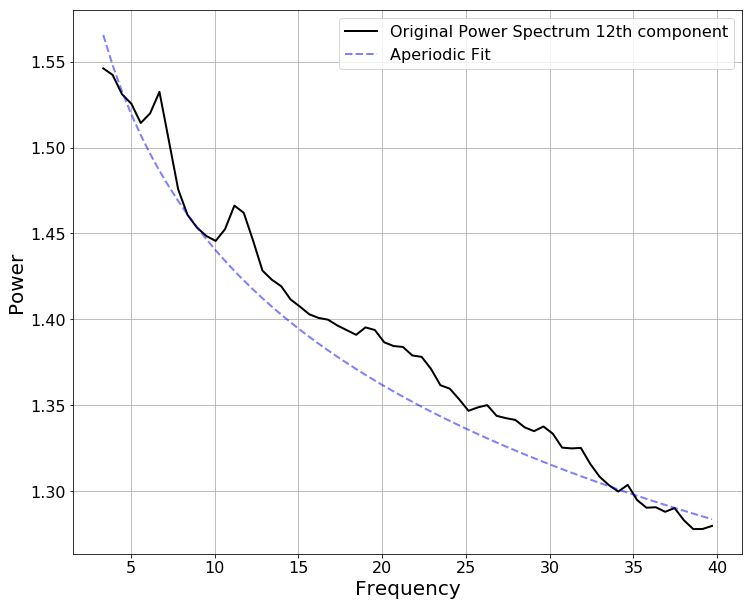

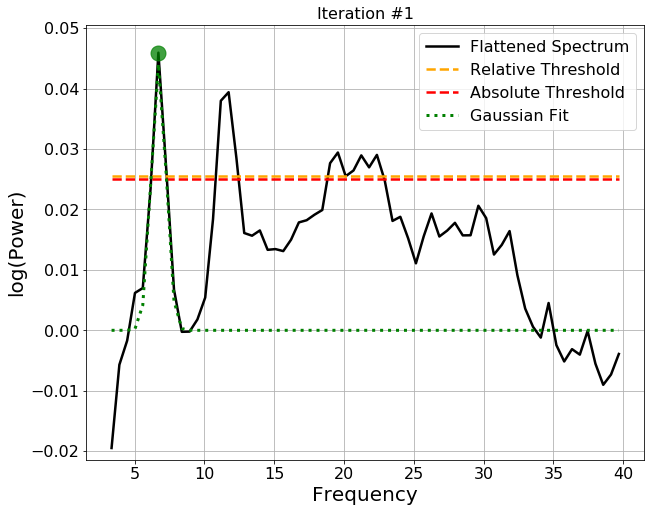

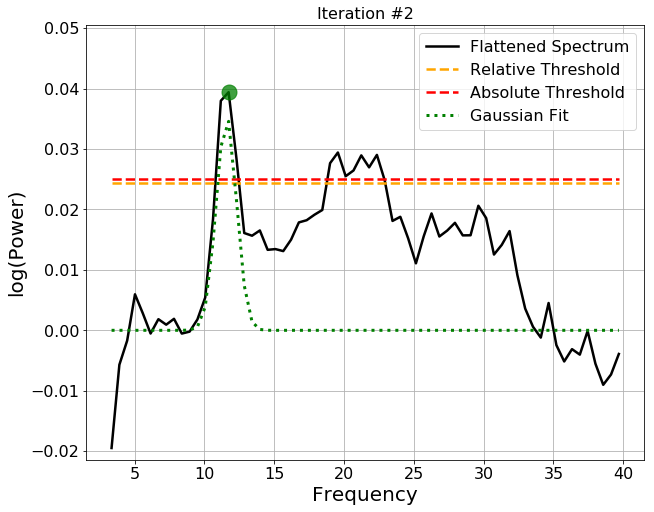

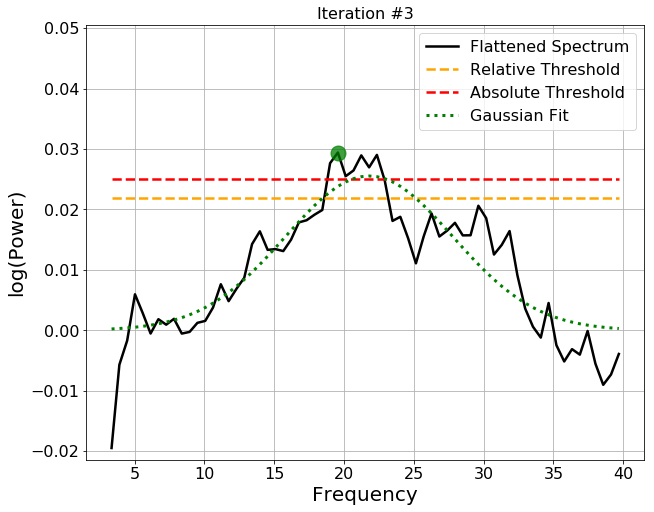

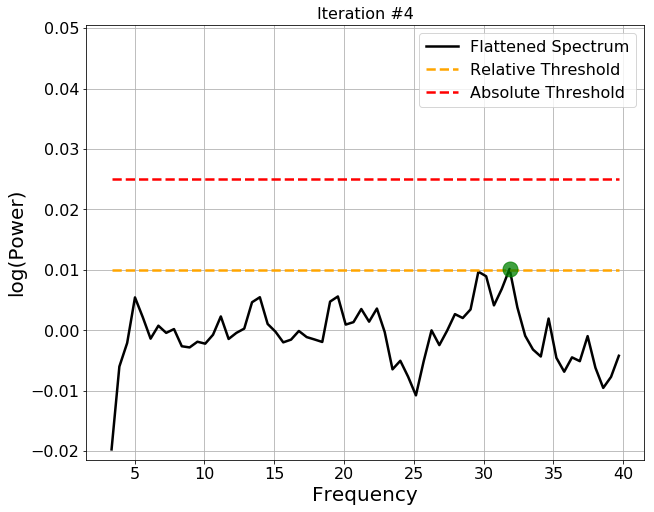

In [30]:
fit_data = group_df['cluster 3']
peak_data = fit_data['peak data']['CF']
component_size = int(np.size(fit_data['data']['spectra'])/np.size(fit_data['data']['freqs']))
spectra_cl = fit_data['data']['spectra']
freqs_cl = fit_data['data']['freqs']

# plot settings
# fig, axs = plt.subplots(component_size, 1)
# fig = plt.figure()
# fig.set_figheight(120)
# fig.set_figwidth(60)
# gs = fig.add_gridspec(component_size,1)
# fig, axs = plt.subplots(sharex=True, sharey=True)

cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

# locate components that have peaks
peak_comps = peak_data[:,1] #components that have peaks
bumpy_comps = set([int(i) for i in peak_comps]) # articulate the components

#loop through components in the cluster, extract component spectra
for comp in range(component_size):
    component_spectra = []
    for i in spectra_cl:
        component_spectra.append(i[comp])
    component_spectra = np.array(component_spectra)
    
    # FOOOF set up
    fm = fooof.FOOOF(aperiodic_mode='fixed', verbose = False, min_peak_height = 0.025)
    # fm = fooof.FOOOF(peak_width_limits=[1.0, 8.0], max_n_peaks=6, min_peak_height=0.1,peak_threshold=2.0, aperiodic_mode='fixed')
    plt_log = False
    freq_range = [3, 40]
    fm.fit(freqs_cl, component_spectra, freq_range)
    fm.report()
    
    # Fit
    ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))
    _, ax = plt.subplots(figsize=(12, 10))
    print(str(comp)+'th component')
    plot_spectrum(fm.freqs, fm.power_spectrum, plt_log, label='Original Power Spectrum '+ str(comp) + 'th component', color='black', ax=ax)
    plot_spectrum(fm.freqs, ap_fit, plt_log, label='Aperiodic Fit', color='blue', alpha=0.5, linestyle='dashed', ax=ax)
    
    # plot_peak_fits(peak_data, freq_range=freq_range, colors='red', labels='Peaks', ax=ax)
    # error
    flatspec = fm.power_spectrum - ap_fit
    ylims = [min(flatspec) - 0.1 * np.abs(min(flatspec)), max(flatspec) + 0.1 * max(flatspec)]
    # plot_spectrum(fm.freqs, flatspec, ax=ax, plot_style=None,label='Flattened Spectrum', color='black', linewidth=2.5)
    # plot_spectrum(fm.freqs, [fm.peak_threshold * np.std(flatspec)]*len(fm.freqs), label='Relative Threshold', color='orange', linestyle='dashed', ax=ax)
    # plot_spectrum(fm.freqs, [fm.min_peak_height]*len(fm.freqs), label='Absolute Threshold', color='red', linestyle='dashed', ax=ax)
    
    
    
    peak_freqs = []
    if comp in bumpy_comps:
        # i[0]: CF; i[1]: component index
        for i in peak_data:
            if i[1] == comp:
                peak_value = i[0]
                peak_freqs.append(i[0])
                print(str(comp+1)+ 'th ' + str(i[0]))
    
    markers_on = [_prox_query(peak,component_spectra) for peak in peak_freqs]
    
    # peak search
    plot_annotated_peak_search(fm)
    
    # plot settings
    # axs[comp].plot(freqs_cl, component_spectra, '-gD', markevery=markers_on)
    # axs[comp].title.set_text(str(comp+1)+ 'th')
    # axs[comp].set_xlim([0, 100])

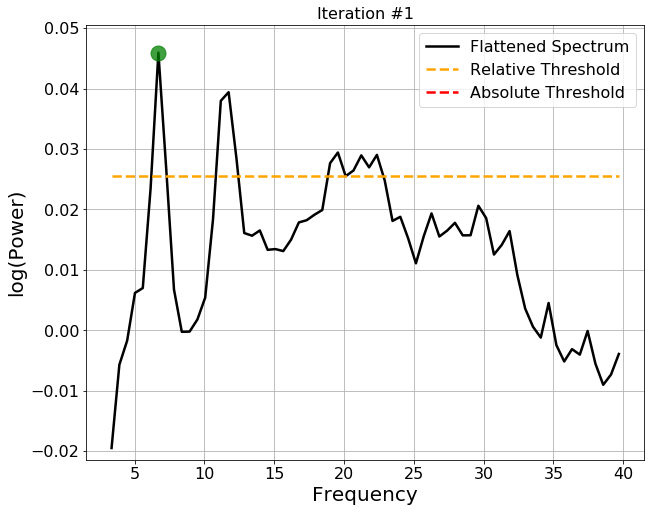

In [11]:
plot_annotated_peak_search(fm)

## Alpha Band Peaks

#### Defining Frequency Band

In [28]:
group_df

{'cluster 3': {'spectral exponent': array([0.28477276, 0.25031992, 0.04127096, 0.24320284, 0.23123645,
         0.11700827, 0.11411657, 0.24441423, 0.21615753, 0.22278352,
         0.25937738, 0.22321604, 0.23910258]),
  'peak data': {'CF': array([[ 6.5904143 ,  0.        ],
          [10.94044093,  0.        ],
          [21.53618419,  0.        ],
          [ 9.09749922,  1.        ],
          [19.79270958,  1.        ],
          [ 9.39620617,  2.        ],
          [ 9.34714666,  3.        ],
          [ 9.93792466,  4.        ],
          [ 6.31183919,  5.        ],
          [ 9.67555968,  5.        ],
          [ 6.35239345,  6.        ],
          [ 9.74081562,  6.        ],
          [10.09966852,  8.        ],
          [10.6040315 ,  9.        ],
          [20.80207392,  9.        ],
          [12.89171189, 10.        ],
          [ 6.71537929, 12.        ],
          [11.64079257, 12.        ]]),
   'PW': array([[ 0.08008538,  0.        ],
          [ 0.02640353,  0.     

In [7]:
# Define frequency bands of interest
bands = Bands({'theta' : [4, 8], 'alpha' : [8, 13], 'beta' : [13, 30]})

#### General dataset

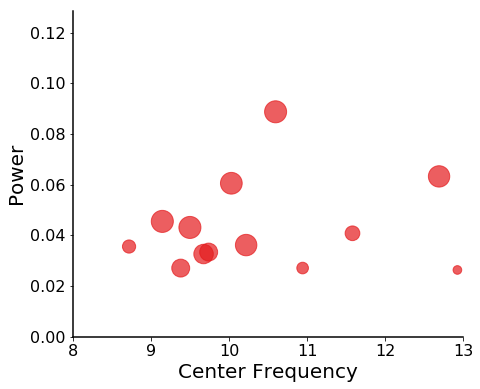

In [12]:
# extract peaks from each group
alphas_peaks = get_band_peak_fg(fg, bands.alpha)
plot_peak_params(alphas_peaks, freq_range=bands.alpha)

### Conditioins

In [14]:
peak_value = 6.590414295233727

In [15]:
fm.freqs[6]

6.707423580786026

In [16]:
fm.freqs

array([ 3.35371179,  3.91266376,  4.47161572,  5.03056769,  5.58951965,
        6.14847162,  6.70742358,  7.26637555,  7.82532751,  8.38427948,
        8.94323144,  9.50218341, 10.06113537, 10.62008734, 11.1790393 ,
       11.73799127, 12.29694323, 12.8558952 , 13.41484716, 13.97379913,
       14.53275109, 15.09170306, 15.65065502, 16.20960699, 16.76855895,
       17.32751092, 17.88646288, 18.44541485, 19.00436681, 19.56331878,
       20.12227074, 20.68122271, 21.24017467, 21.79912664, 22.3580786 ,
       22.91703057, 23.47598253, 24.0349345 , 24.59388646, 25.15283843,
       25.71179039, 26.27074236, 26.82969432, 27.38864629, 27.94759825,
       28.50655022, 29.06550218, 29.62445415, 30.18340611, 30.74235808,
       31.30131004, 31.86026201, 32.41921397, 32.97816594, 33.5371179 ,
       34.09606987, 34.65502183, 35.2139738 , 35.77292576, 36.33187773,
       36.89082969, 37.44978166, 38.00873362, 38.56768559, 39.12663755,
       39.68558952])

In [17]:
fit_data = group_df['cluster 3']
peak_data = fit_data['peak data']['CF']
component_size = int(np.size(fit_data['data']['spectra'])/np.size(fit_data['data']['freqs']))
spectra_cl = fit_data['data']['spectra']
freqs_cl = fit_data['data']['freqs']

log_spectea_cl = np.log(spectra_cl)

# plot settings
fig = plt.figure()
fig.set_figheight(10)
fig.set_figwidth(10)

cmap = LinearSegmentedColormap.from_list('mycmap', ['#111d6c', '#e03694'])
color = cmap(np.linspace(0, 1,n_))
mpl.rcParams['axes.prop_cycle'] = cycler.cycler('color', color)

# locate components that have peaks
peak_comps = peak_data[:,1] #components that have peaks
bumpy_comps = set([int(i) for i in peak_comps])
#loop through components in the cluster
for comp in range(13):
    component_spectra = []
    x_coor = freqs_cl
    for i in log_spectea_cl:
        component_spectra.append(i[comp])
    y_coor = np.array(component_spectra)
    
    peak_freqs = []
    if comp in bumpy_comps:
        for i in peak_data:
            if i[1] == comp:
                peak_freqs.append(i[0])
                print(str(comp+1)+ 'th ' + str(i[0]))
    markers_on = [_prox_query(p,component_spectra) for p in peak_freqs]
    print(markers_on)
    # plot the ap fit
    # converting to array
    component_spectra_ar = np.asarray(component_spectra)
    fm = fooof.FOOOF()
    fm.add_data(freqs_cl, y_coor,[3, 40])
    fm.fit(freqs_cl, y_coor, [3, 40])
    init_ap_fit = gen_aperiodic(fm.freqs, fm._robust_ap_fit(fm.freqs, fm.power_spectrum))

    # plot settings
    # plt.plot(x_coor, y_coor, '-gD', markevery=markers_on)
    # plt.title(str(comp+1)+ 'th')
    # plt.xlim(3, 40)
    
    # plt.plot(init_ap_fit, label = "aperiodic fit")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


1th 6.590414295892744
1th 10.940440926709051
1th 21.536184190787942
[0, 0, 0]

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

2th 9.097499223079337
2th 19.792709579680867
[1, 1]

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

3th 9.396206173096482
[1]

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 0.56 <= 0.50
	Lower bounds below frequency-resolution have

<Figure size 720x720 with 0 Axes>

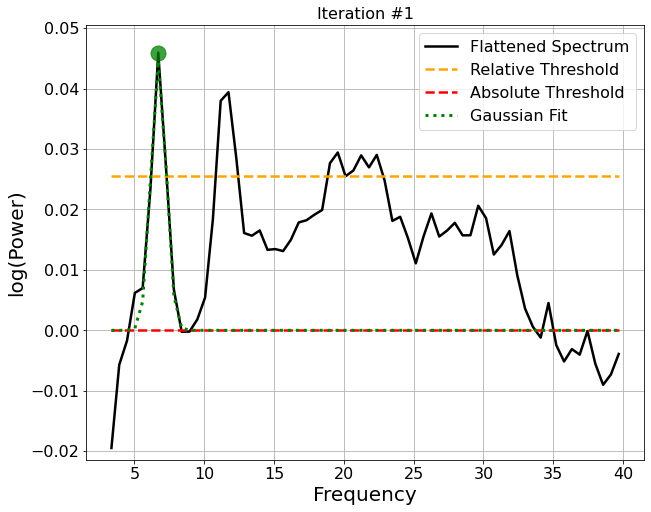

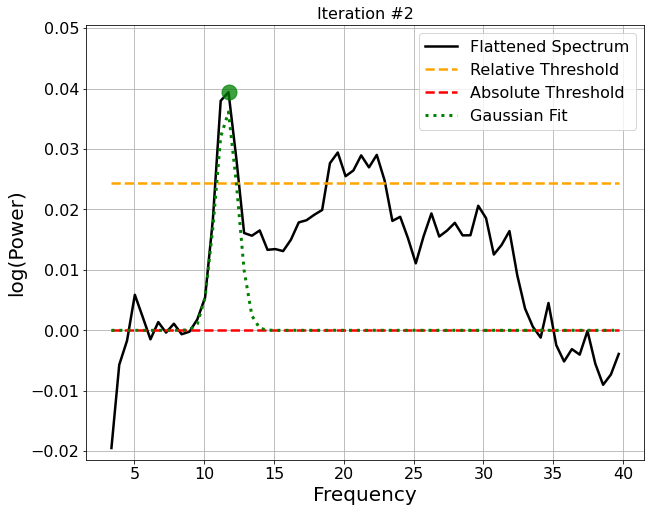

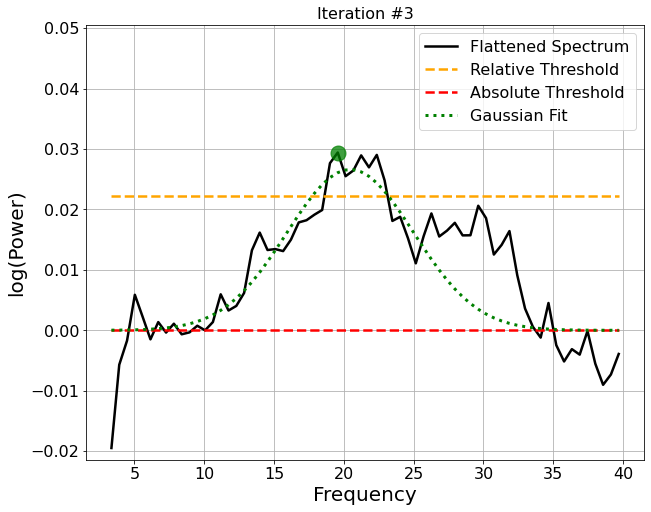

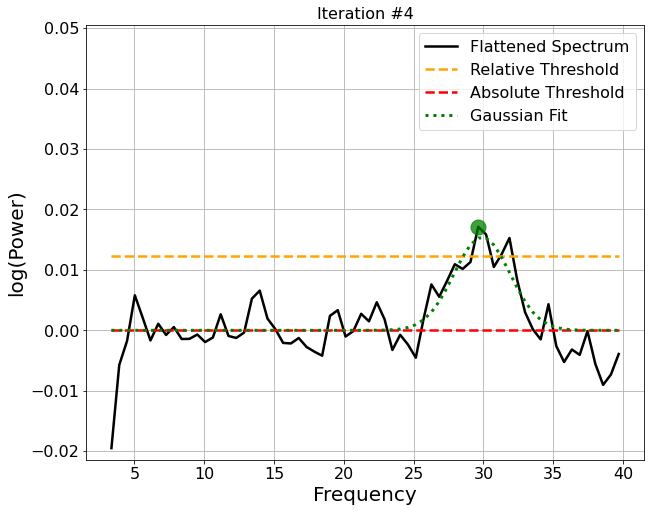

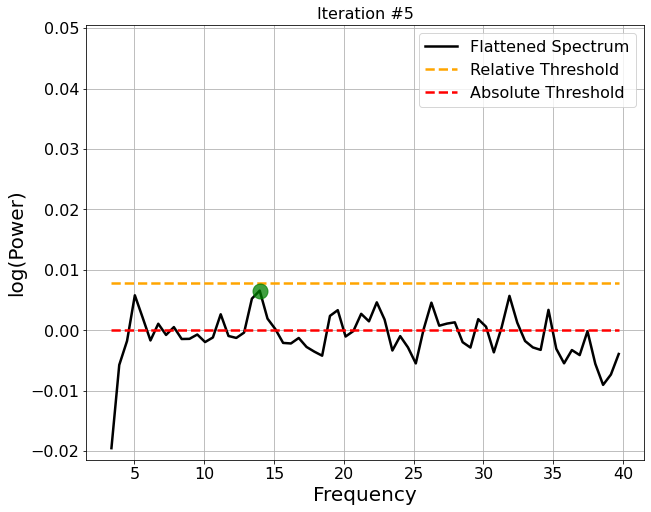

In [20]:
plot_annotated_peak_search(fm)